In [0]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! ls

drive  sample_data


In [0]:
!pwd


/content


In [0]:
%cd "/content/drive/My Drive/Colab Notebooks/CSCI599"

/content/drive/My Drive/Colab Notebooks/CSCI599


In [0]:
# !git clone https://github.com/shaoanlu/faceswap-GAN.git

Cloning into 'faceswap-GAN'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 996 (delta 0), reused 1 (delta 0), pack-reused 993
Receiving objects: 100% (996/996), 2.21 MiB | 1.92 MiB/s, done.
Resolving deltas: 100% (606/606), done.


In [0]:
!ls

colab_demo
converter
data_loader
detector
FaceSwap_GAN_v2.2_train_test.ipynb
FaceSwap_GAN_v2.2_video_conversion.ipynb
image_augmentation.py
legacy
mtcnn_detect_face.py
MTCNN_video_face_detection_alignment.ipynb
mtcnn_weights
networks
notes
prep_binary_masks.ipynb
preprocess.py
README.md
umeyama.py
utils.py


In [0]:
%cd "/content/drive/My Drive/Colab Notebooks/CSCI599/faceswap-GAN"

/content/drive/My Drive/Colab Notebooks/CSCI599/faceswap-GAN


In [0]:
from google.colab import files

In [0]:
source_video = "/content/drive/My Drive/Colab Notebooks/CSCI599/faceswap-GAN/MikeZyda.mp4"

In [0]:
target_video = "/content/drive/My Drive/Colab Notebooks/CSCI599/faceswap-GAN/TomCruise.mp4"

In [0]:
global TOTAL_ITERS
TOTAL_ITERS = 20000

In [0]:
%%capture
!pip install moviepy
!pip install keras_vggface
import imageio
imageio.plugins.ffmpeg.download()

In [0]:
import keras.backend as K
from detector.face_detector import MTCNNFaceDetector
import glob

from preprocess import preprocess_video

Using TensorFlow backend.


In [0]:
fd = MTCNNFaceDetector(sess=K.get_session(), model_path="./mtcnn_weights/")









Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



In [0]:


# !mkdir -p faceA/rgb
# !mkdir -p faceA/binary_mask
# !mkdir -p faceB/rgb
# !mkdir -p faceB/binary_mask

In [0]:
# save_interval = 3 # perform face detection every {save_interval} frames
# save_path = "./faceA/"
# preprocess_video(source_video, fd, save_interval, save_path)
# save_path = "./faceB/"
# preprocess_video(target_video, fd, save_interval, save_path)

100%|██████████| 2100/2100 [02:12<00:00, 15.87it/s]


In [0]:
########## Run from here



print(str(len(glob.glob("faceA/rgb/*.*"))) + " face(s) extracted from source vide")
print(str(len(glob.glob("faceB/rgb/*.*"))) + " face(s) extracted from target video: ")

731 face(s) extracted from source vide
700 face(s) extracted from target video: 


In [0]:
from keras.layers import *
import keras.backend as K
import tensorflow as tf

In [0]:
import os
import cv2
import glob
import time
import numpy as np
from pathlib import PurePath, Path
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
K.set_learning_phase(1)
# Number of CPU cores
num_cpus = os.cpu_count()

# Input/Output resolution
RESOLUTION = 64 # 64x64, 128x128, 256x256
assert (RESOLUTION % 64) == 0, "RESOLUTION should be 64, 128, or 256."

# Batch size
batchSize = 4

# Use motion blurs (data augmentation)
# set True if training data contains images extracted from videos
use_da_motion_blur = False 

# Use eye-aware training
# require images generated from prep_binary_masks.ipynb
use_bm_eyes = True

# Probability of random color matching (data augmentation)
prob_random_color_match = 0.5

da_config = {
    "prob_random_color_match": prob_random_color_match,
    "use_da_motion_blur": use_da_motion_blur,
    "use_bm_eyes": use_bm_eyes
}

# Path to training images
img_dirA = './faceA/rgb'
img_dirB = './faceB/rgb'
img_dirA_bm_eyes = "./faceA/binary_mask"
img_dirB_bm_eyes = "./faceB/binary_mask"

# Path to saved model weights
models_dir = "./models"

# Architecture configuration
arch_config = {}
arch_config['IMAGE_SHAPE'] = (RESOLUTION, RESOLUTION, 3)
arch_config['use_self_attn'] = True
arch_config['norm'] = "hybrid" # instancenorm, batchnorm, layernorm, groupnorm, none
arch_config['model_capacity'] = "lite" # standard, lite

# Loss function weights configuration
loss_weights = {}
loss_weights['w_D'] = 0.1 # Discriminator
loss_weights['w_recon'] = 1. # L1 reconstruction loss
loss_weights['w_edge'] = 0.1 # edge loss
loss_weights['w_eyes'] = 30. # reconstruction and edge loss on eyes area
loss_weights['w_pl'] = (0.01, 0.1, 0.3, 0.1) # perceptual loss (0.003, 0.03, 0.3, 0.3)

# Init. loss config.
loss_config = {}
loss_config["gan_training"] = "mixup_LSGAN"
loss_config['use_PL'] = False
loss_config["PL_before_activ"] = True
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.
loss_config['lr_factor'] = 1.
loss_config['use_cyclic_loss'] = False

In [0]:
from networks.faceswap_gan_model import FaceswapGANModel
from data_loader.data_loader import DataLoader
from utils import showG, showG_mask, showG_eyes

In [0]:
#%tensorflow_version 1.x magic: more

In [0]:
model = FaceswapGANModel(**arch_config)
#REMOVE FOR TRAINING FROM SCRATCH
#model.load_weights(path=models_dir)

In [0]:
%%capture
!wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_resnet50.h5

In [0]:
#from keras_vggface.vggface import VGGFace

# VGGFace ResNet50
#vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))'

from colab_demo.vggface_models import RESNET50
vggface = RESNET50(include_top=False, weights=None, input_shape=(224, 224, 3))
vggface.load_weights("rcmalli_vggface_tf_notop_resnet50.h5")

#from keras.applications.resnet50 import ResNet50
#vggface = ResNet50(include_top=False, input_shape=(224, 224, 3))

#vggface.summary()

model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])
model.build_train_functions(loss_weights=loss_weights, **loss_config)





Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.





In [0]:
# Create ./models directory
Path(f"models").mkdir(parents=True, exist_ok=True)

In [0]:
# Get filenames
train_A = glob.glob(img_dirA+"/*.*")
train_B = glob.glob(img_dirB+"/*.*")

train_AnB = train_A + train_B

assert len(train_A), "No image found in " + str(img_dirA)
assert len(train_B), "No image found in " + str(img_dirB)
print ("Number of images in folder A: " + str(len(train_A)))
print ("Number of images in folder B: " + str(len(train_B)))

Number of images in folder A: 731
Number of images in folder B: 700


In [0]:
def show_loss_config(loss_config):
    for config, value in loss_config.items():
        print(f"{config} = {value}")

In [0]:
def reset_session(save_path):
    global model, vggface
    global train_batchA, train_batchB
    model.save_weights(path=save_path)
    del model
    del vggface
    del train_batchA
    del train_batchB
    K.clear_session()
    model = FaceswapGANModel(**arch_config)
    model.load_weights(path=save_path)
    #vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))
    vggface = RESNET50(include_top=False, weights=None, input_shape=(224, 224, 3))
    vggface.load_weights("rcmalli_vggface_tf_notop_resnet50.h5")
    model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])
    train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes,
                              RESOLUTION, num_cpus, K.get_session(), **da_config)
    train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                              RESOLUTION, num_cpus, K.get_session(), **da_config)

gan_training = mixup_LSGAN
use_PL = True
PL_before_activ = True
use_mask_hinge_loss = False
m_mask = 0.0
lr_factor = 0.1
use_cyclic_loss = False
----------
[iter 19800] Loss_DA: 0.219001 Loss_DB: 0.192849 Loss_GA: 1.335254 Loss_GB: 1.302654 time: 12641.594018
----------
Generator loss details:
[Adversarial loss]
GA: 0.1201 GB: 0.1290
[Reconstruction loss]
GA: 0.4143 GB: 0.4482
[Edge loss]
GA: 0.4603 GB: 0.3939
[Perceptual loss]
GA: 0.1954 GB: 0.1881
----------
Transformed (masked) results:


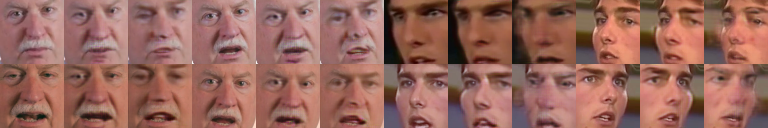

Masks:


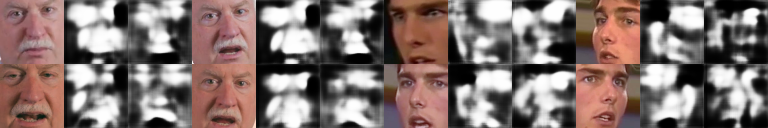

Reconstruction results:


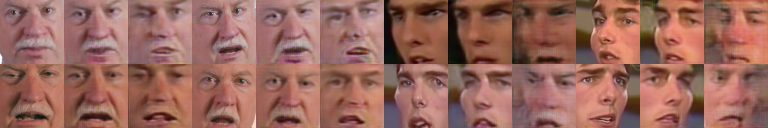

Model weights files have been saved to ./models.


In [0]:
t0 = time.time()
#gen_iterations=25000
# This try/except is meant to resume training if we disconnected from Colab
try:
    gen_iterations
    print(f"Resume training from iter {gen_iterations}.")
except:
    gen_iterations = 0

errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
errGAs = {}
errGBs = {}
# Dictionaries are ordered in Python 3.6
for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
    errGAs[k] = 0
    errGBs[k] = 0

display_iters = 300
global TOTAL_ITERS

global train_batchA, train_batchB
train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
print('im in',gen_iterations,TOTAL_ITERS)

while gen_iterations <= TOTAL_ITERS: 
    #print('iter',gen_iterations)
    # Loss function automation
    if gen_iterations == (TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//5 + TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.5
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Complete.")
    elif gen_iterations == (2*TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.2
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//2 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.4
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (2*TOTAL_ITERS//3 - display_iters//2):
        clear_output()
        model.decoder_A.load_weights("models/decoder_B.h5") # swap decoders
        model.decoder_B.load_weights("models/decoder_A.h5") # swap decoders
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.5
        loss_config['lr_factor'] = 1
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (8*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.1
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (9*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        loss_config['lr_factor'] = 0.1
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    
    if gen_iterations == 5:
        print ("working.")
    
    # Train dicriminators for one batch
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errDA, errDB = model.train_one_batch_D(data_A=data_A, data_B=data_B)
    errDA_sum +=errDA[0]
    errDB_sum +=errDB[0]

    # Train generators for one batch
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errGA, errGB = model.train_one_batch_G(data_A=data_A, data_B=data_B)
    errGA_sum += errGA[0]
    errGB_sum += errGB[0]
    for i, k in enumerate(['ttl', 'adv', 'recon', 'edge', 'pl']):
        errGAs[k] += errGA[i]
        errGBs[k] += errGB[i]
    gen_iterations+=1
    
    # Visualization
    if gen_iterations % display_iters == 0:
        clear_output()
            
        # Display loss information
        show_loss_config(loss_config)
        print("----------") 
        print('[iter %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
        % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))  
        print("----------") 
        print("Generator loss details:")
        print(f'[Adversarial loss]')  
        print(f'GA: {errGAs["adv"]/display_iters:.4f} GB: {errGBs["adv"]/display_iters:.4f}')
        print(f'[Reconstruction loss]')
        print(f'GA: {errGAs["recon"]/display_iters:.4f} GB: {errGBs["recon"]/display_iters:.4f}')
        print(f'[Edge loss]')
        print(f'GA: {errGAs["edge"]/display_iters:.4f} GB: {errGBs["edge"]/display_iters:.4f}')
        if loss_config['use_PL'] == True:
            print(f'[Perceptual loss]')
            try:
                print(f'GA: {errGAs["pl"][0]/display_iters:.4f} GB: {errGBs["pl"][0]/display_iters:.4f}')
            except:
                print(f'GA: {errGAs["pl"]/display_iters:.4f} GB: {errGBs["pl"]/display_iters:.4f}')
        
        # Display images
        print("----------") 
        wA, tA, _ = train_batchA.get_next_batch()
        wB, tB, _ = train_batchB.get_next_batch()
        print("Transformed (masked) results:")
        showG(tA, tB, model.path_A, model.path_B, batchSize)   
        print("Masks:")
        showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize)  
        print("Reconstruction results:")
        showG(wA, wB, model.path_bgr_A, model.path_bgr_B, batchSize)           
        errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
        for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
            errGAs[k] = 0
            errGBs[k] = 0
        
        # Save models
        model.save_weights(path=models_dir)

In [0]:
from converter.video_converter import VideoConverter

In [0]:
global model, vggface
global train_batchA, train_batchB
del model
del vggface
del train_batchA
del train_batchB
tf.reset_default_graph()
K.clear_session()
model = FaceswapGANModel(**arch_config)
model.load_weights(path=models_dir)

Model weights files are successfully loaded.


In [0]:
fd = MTCNNFaceDetector(sess=K.get_session(), model_path="./mtcnn_weights/")
vc = VideoConverter()
vc.set_face_detector(fd)
vc.set_gan_model(model)

In [0]:
options = {
    # ===== Fixed =====
    "use_smoothed_bbox": True,
    "use_kalman_filter": True,
    "use_auto_downscaling": False,
    "bbox_moving_avg_coef": 0.65,
    "min_face_area": 35 * 35,
    "IMAGE_SHAPE": model.IMAGE_SHAPE,
    # ===== Tunable =====
    "kf_noise_coef": 1e-3,
    "use_color_correction": "hist_match",
    "detec_threshold": 0.8,
    "roi_coverage": 0.9,
    "enhance": 0.,
    "output_type": 3,
    "direction": "AtoB", # ==================== This line determines the transform direction ====================
}

In [0]:
if options["direction"] == "AtoB":
    input_fn = source_video
    output_fn = "OUTPUT_VIDEO_AtoB.mp4"
elif options["direction"] == "BtoA":
    input_fn = target_video
    output_fn = "OUTPUT_VIDEO_BtoA.mp4"


In [0]:
duration = None

In [0]:
vc.convert(input_fn=input_fn, output_fn=output_fn, options=options, duration=duration)

[MoviePy] >>>> Building video OUTPUT_VIDEO_AtoB.mp4
[MoviePy] Writing audio in OUTPUT_VIDEO_AtoBTEMP_MPY_wvf_snd.mp3


100%|██████████| 1609/1609 [00:02<00:00, 612.79it/s]

[MoviePy] Done.
[MoviePy] Writing video OUTPUT_VIDEO_AtoB.mp4



100%|██████████| 1750/1750 [11:52<00:00,  2.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: OUTPUT_VIDEO_AtoB.mp4 



In [0]:
from google.colab import files
if options["direction"] == "AtoB":
    files.download("OUTPUT_VIDEO_AtoB.mp4")
elif options["direction"] == "BtoA":
    files.download("OUTPUT_VIDEO_BtoA.mp4")